In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

In [40]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)


# Функционал ошибки mean_absolute_percentage_error (MAPE)
def MAPE(y_true, y_pred): 
    y_true, y_pred = numpy.array(y_true), numpy.array(y_pred)
    return numpy.mean(numpy.abs((y_true - y_pred) / y_true)) * 100


numpy.random.seed(7)

dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [204]:
# Constants:

search_best_config = {
    'iterations': [10, 50, 100, 200],
    'lookback': [1,3,5],
    'batchsize': [1,2],
    'lstm_units': [4,16,32,64,128],
    'epochs': [1]
}

In [51]:
# Baseline (100 iters):
# Train Score: 23.00 RMSE
# Test Score: 56.49 RMSE
# MAPE Score: 9.79 %

In [201]:
def perform_lstm(iterations, lookback, batchsize, lstm_units, epochs, ii):

    look_back = lookback
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    batch_size = batchsize
    model = Sequential()
    model.add(LSTM(lstm_units, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(iterations):
        model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()

    trainPredict = model.predict(trainX, batch_size=batch_size)
    model.reset_states()
    testPredict = model.predict(testX, batch_size=batch_size)

    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    # print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    # print('Test Score: %.2f RMSE' % (testScore))
    mape = MAPE(testY[0], testPredict[:,0])
    # print('MAPE Score: %.2f ' % (mape) + '%')

    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    
    title = str(f'LSTM Parameters... Train RMSE:{round(trainScore, 2)}, \
Test RMSE:{round(testScore,2)}, MAPE: {round(mape,2)}, iterations: {iterations}, \
lookback: {lookback}, batchsize: {batchsize}, lstm_units: {lstm_units}, epochs: {epochs}')
    
    plt.figure(figsize=(16,2))
    plt.title(title)
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.savefig('simple_lstm_animate_%i.png' % (ii + 1))
    plt.show()  
    return iterations, testScore

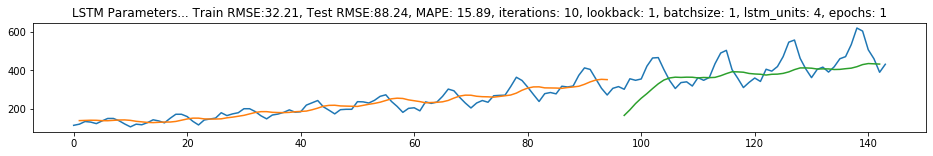

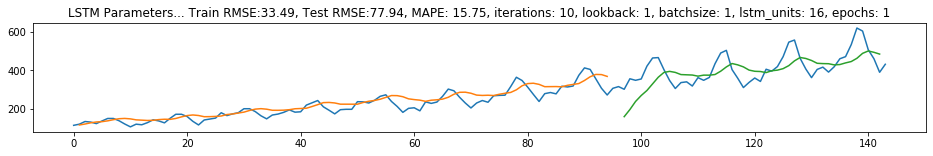

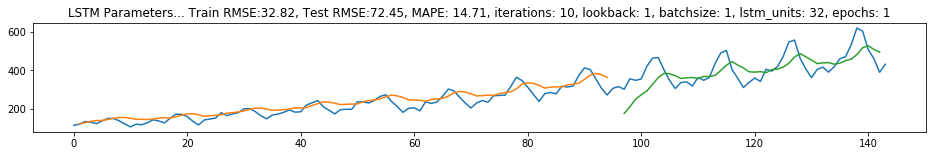

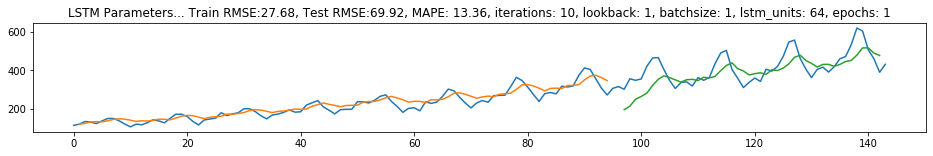

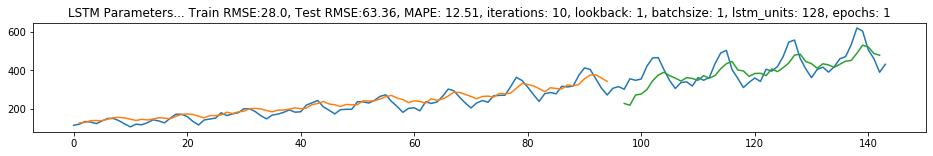

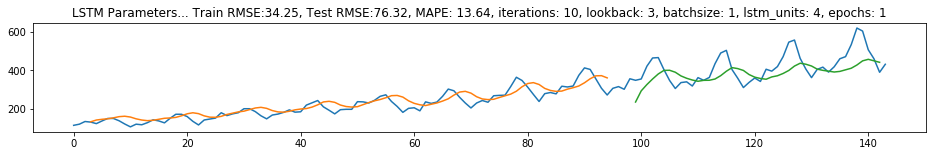

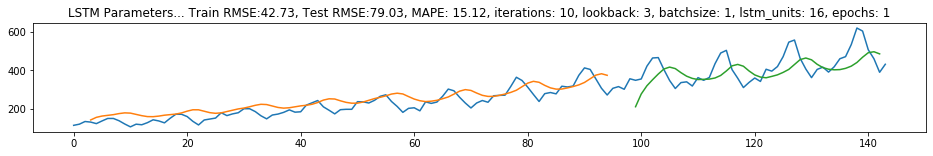

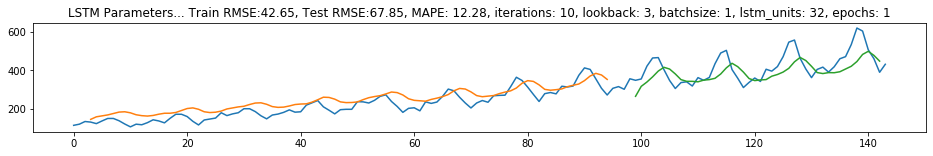

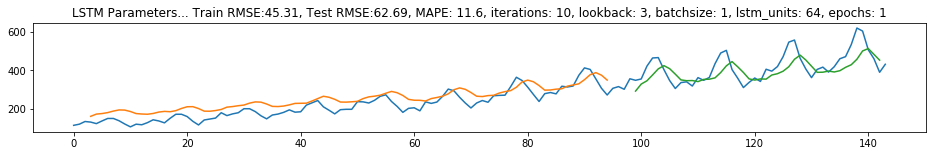

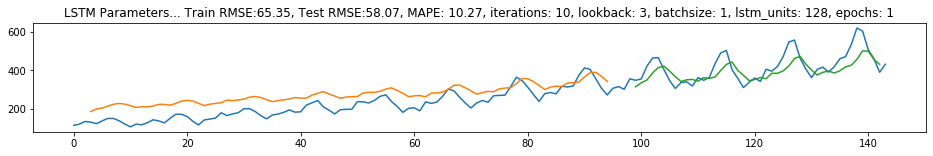

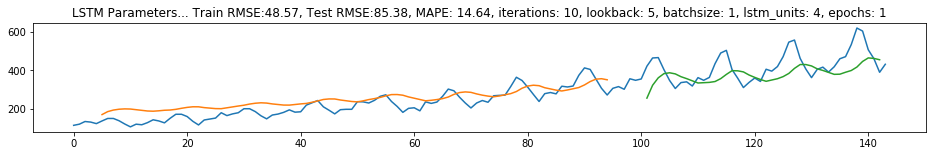

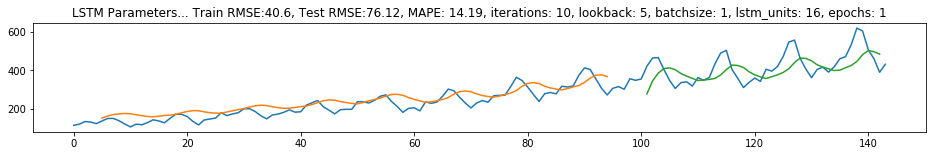

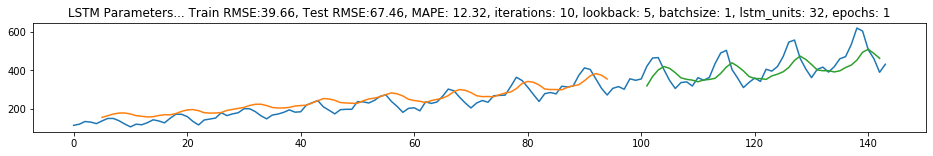

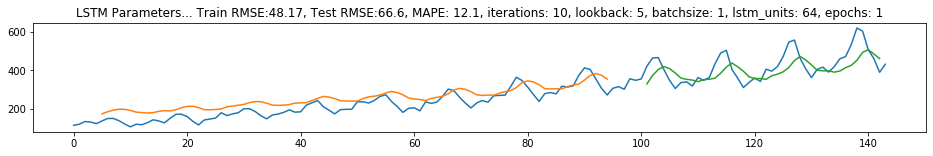

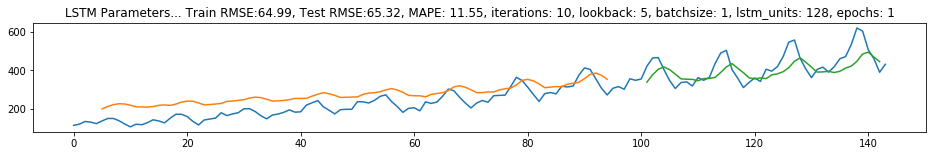

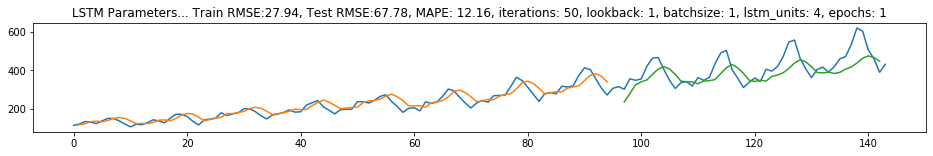

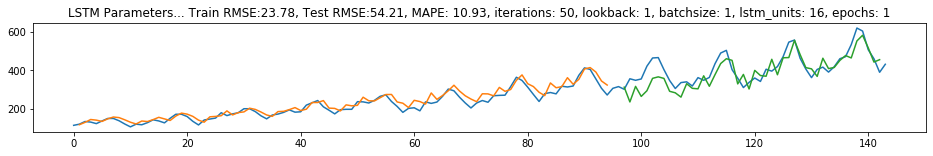

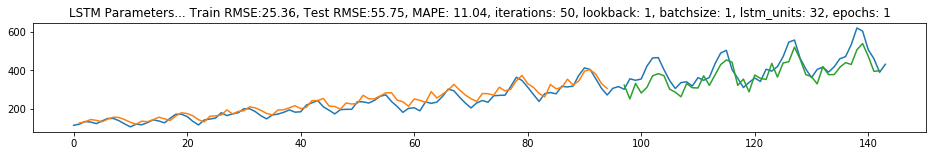

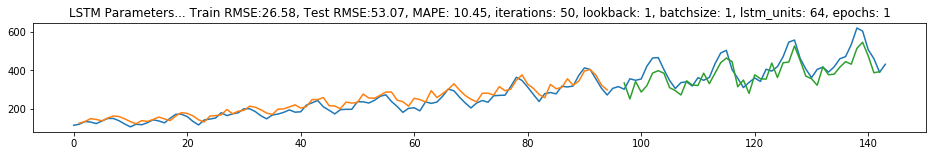

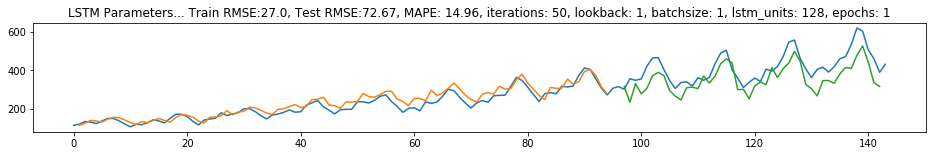

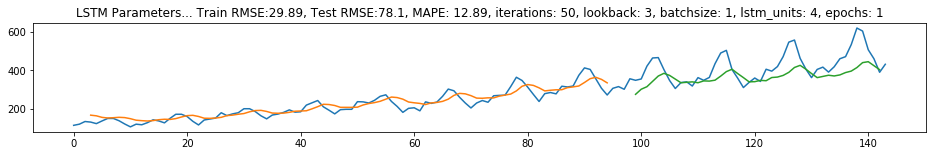

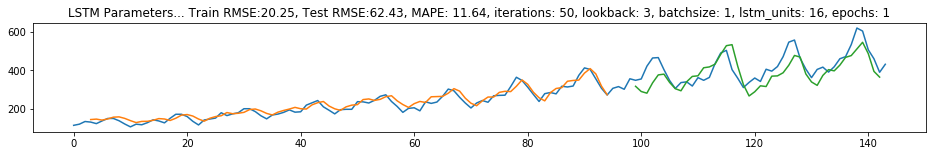

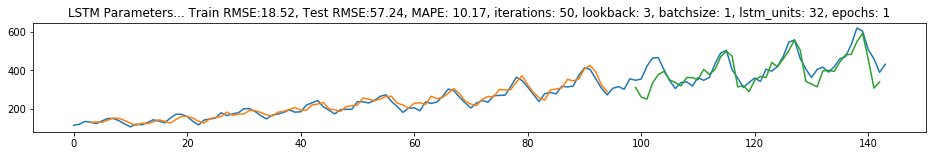

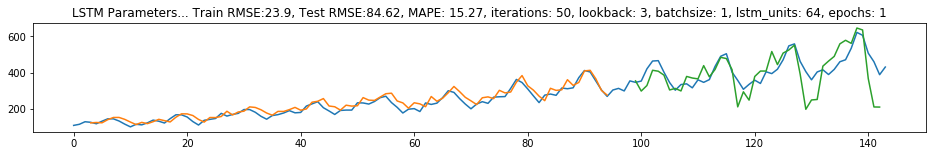

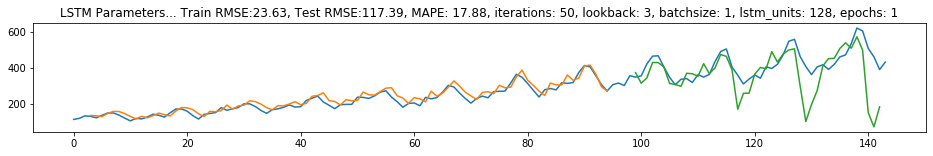

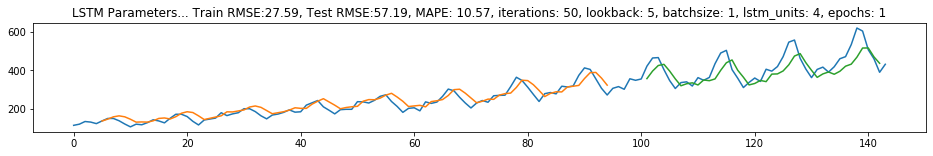

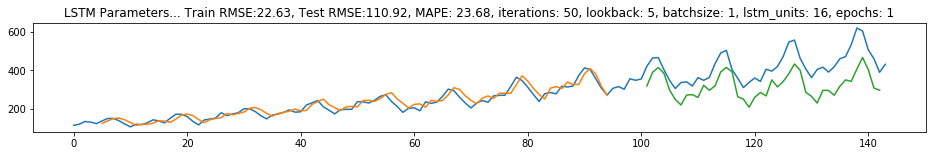

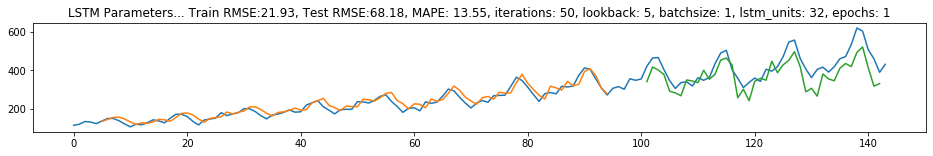

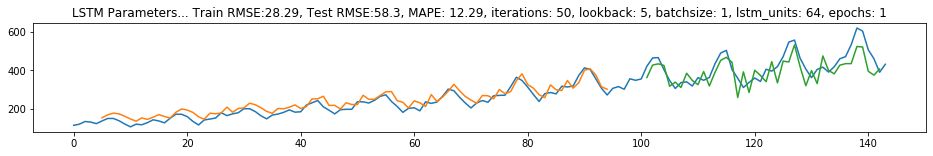

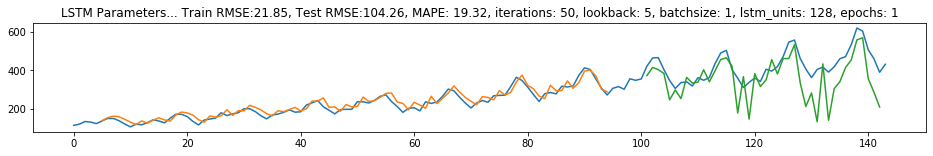

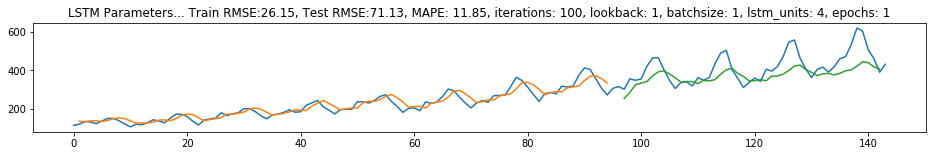

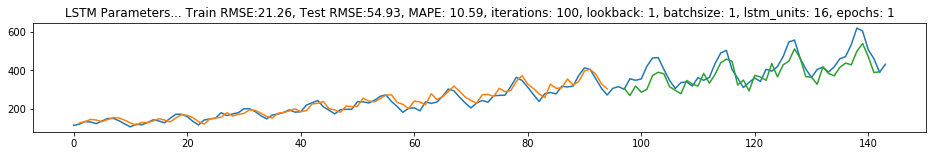

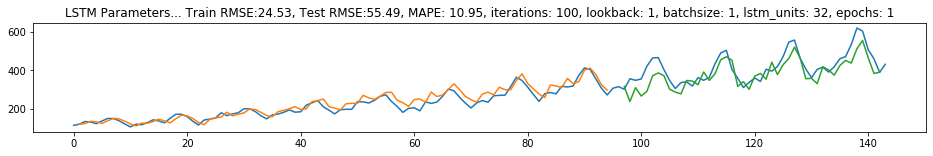

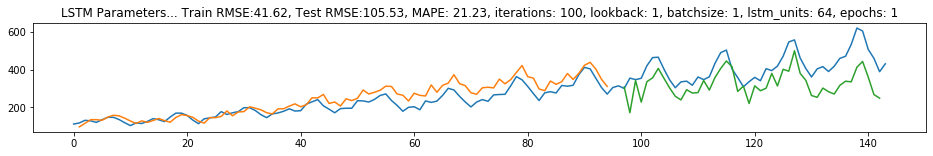

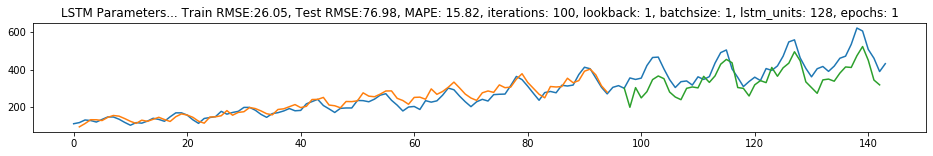

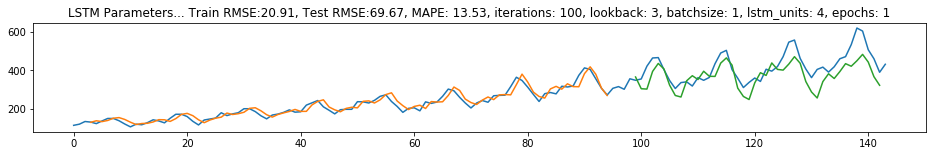

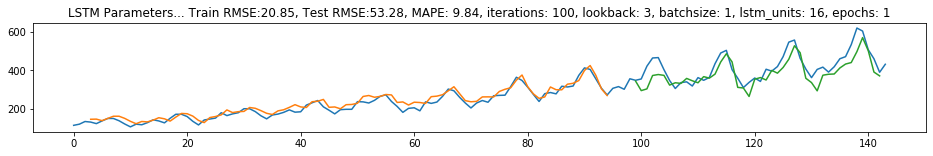

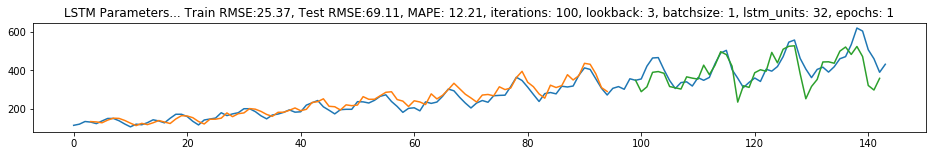

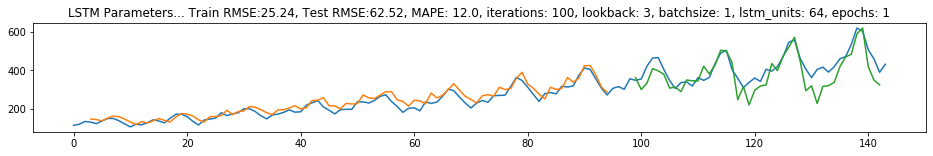

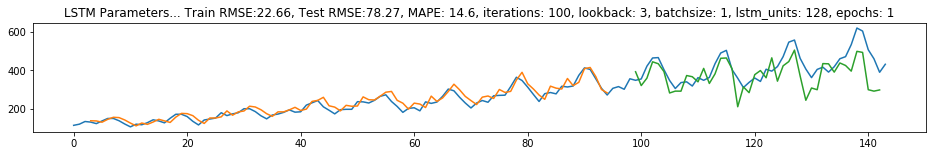

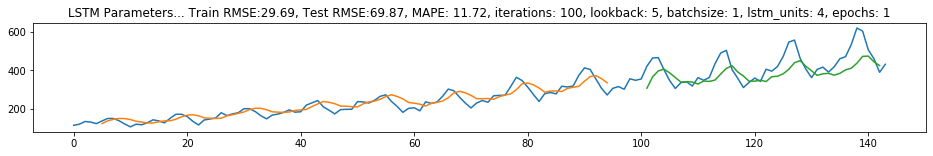

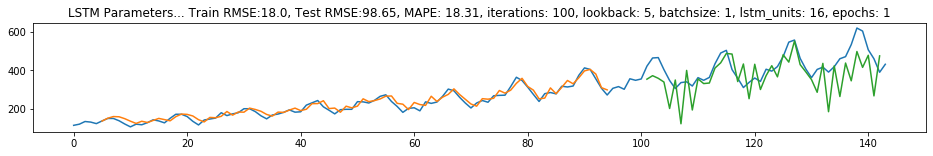

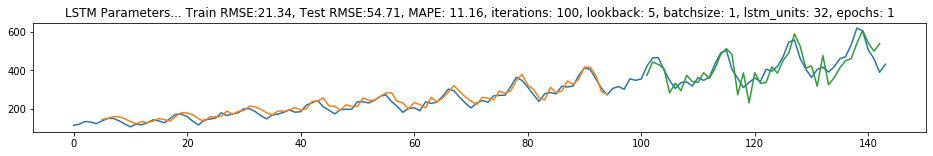

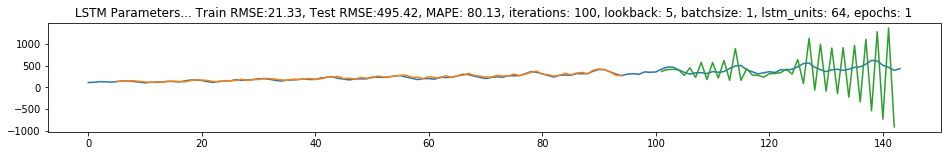

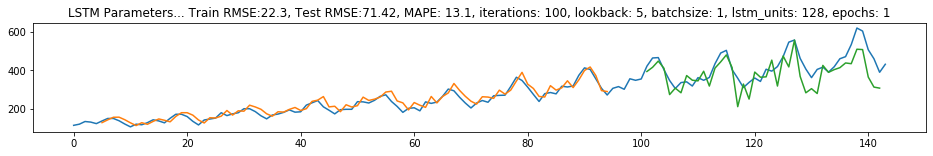

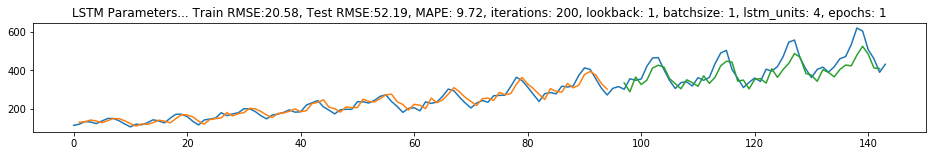

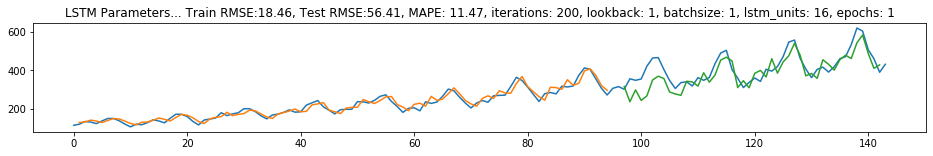

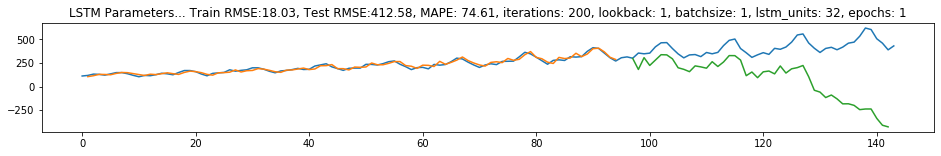

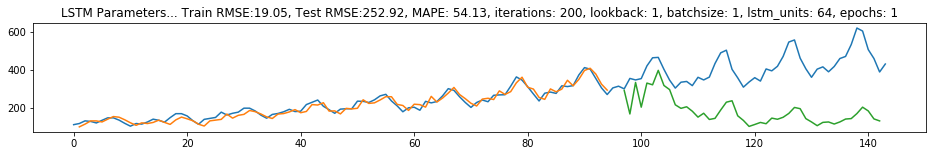

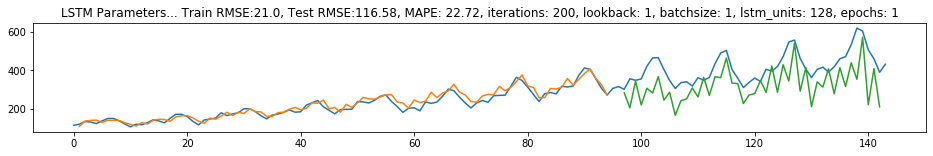

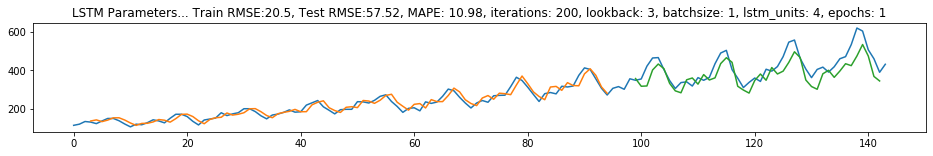

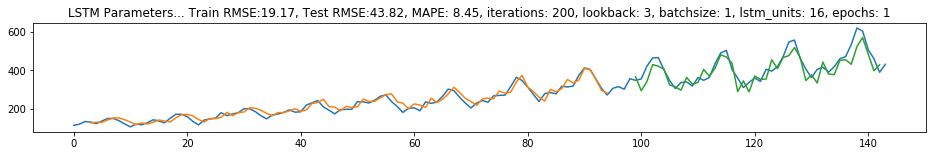

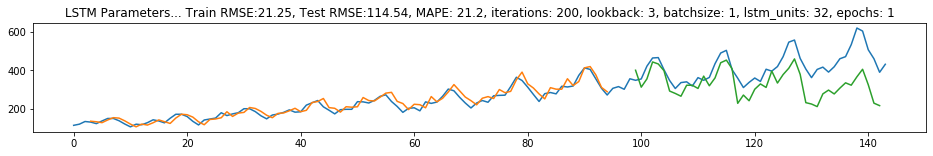

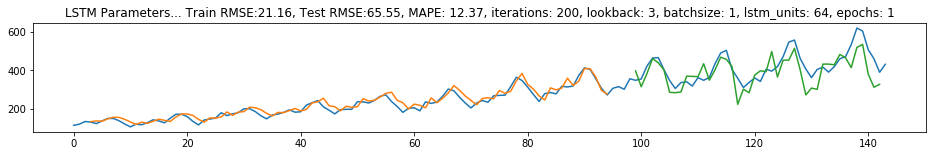

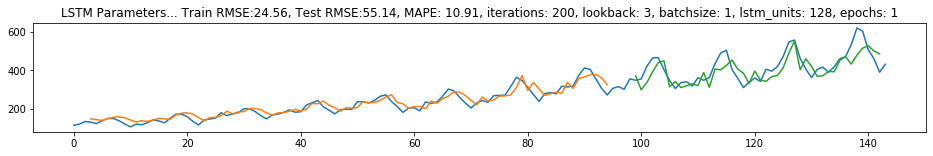

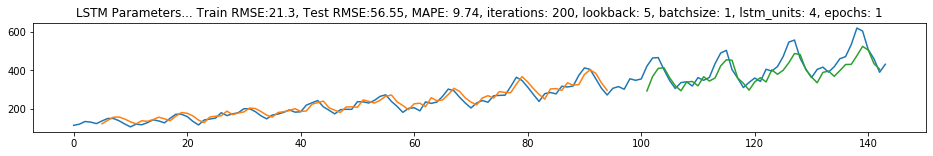

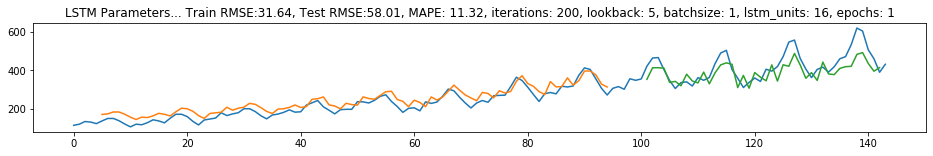

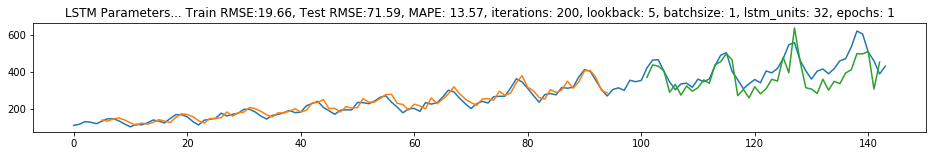

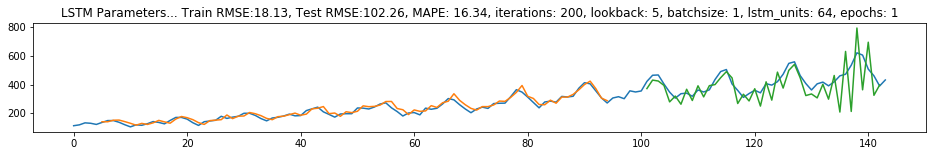

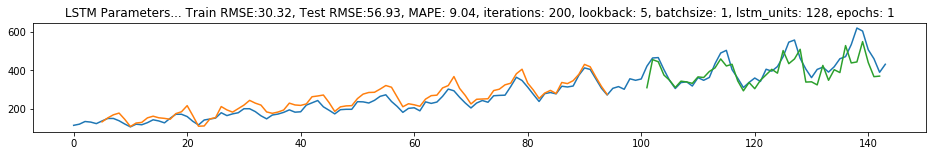

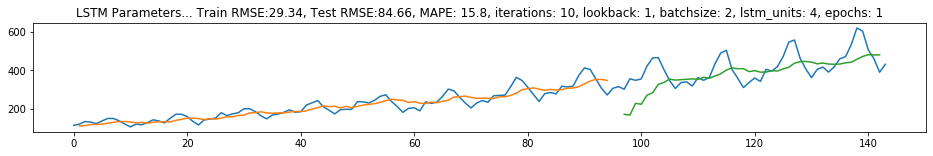

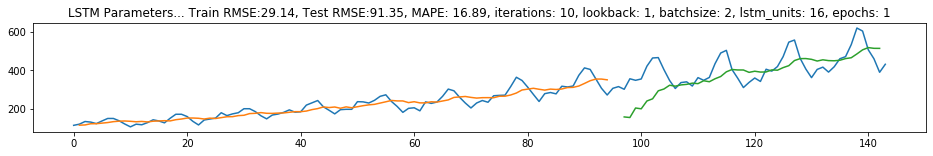

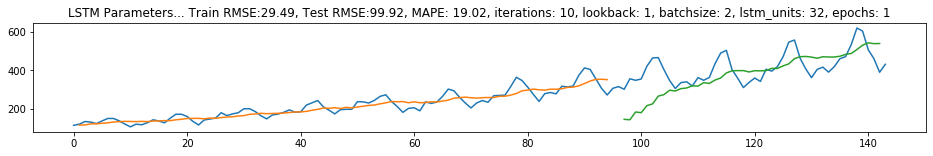

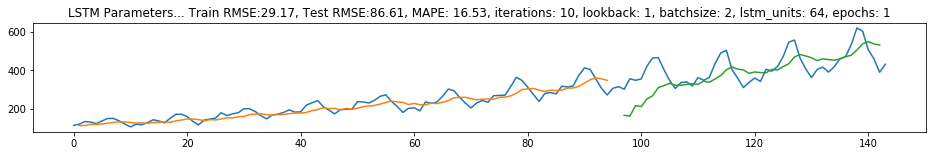

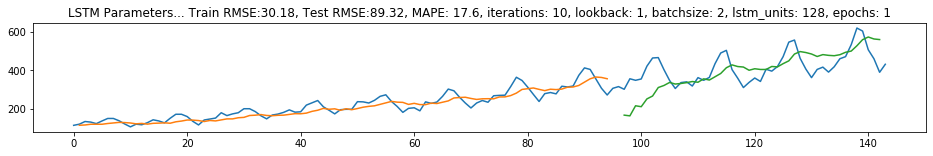

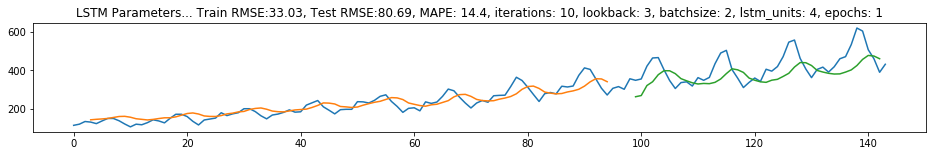

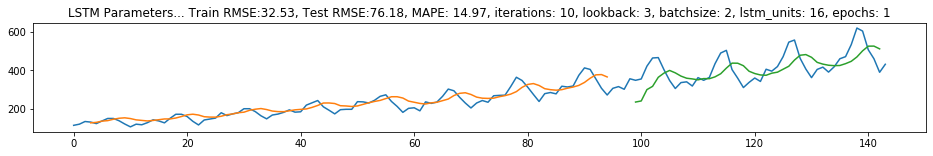

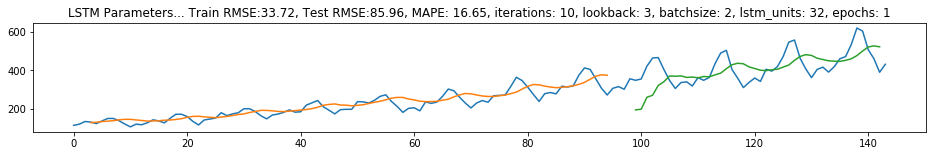

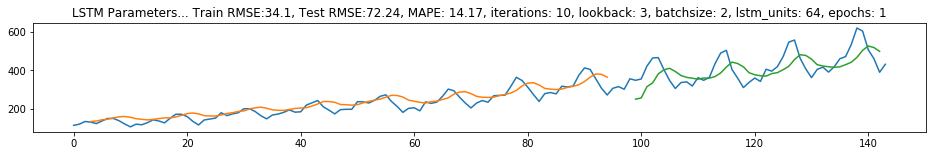

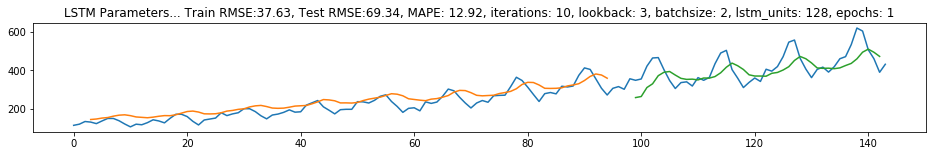

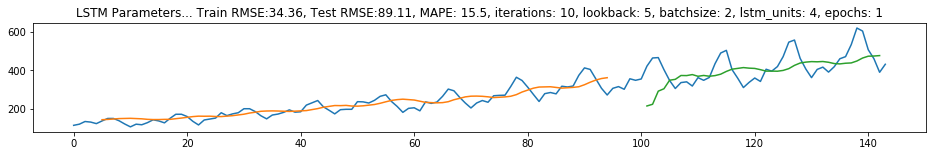

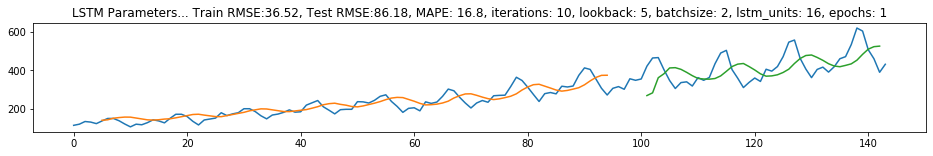

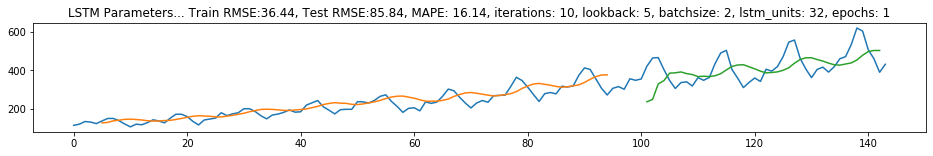

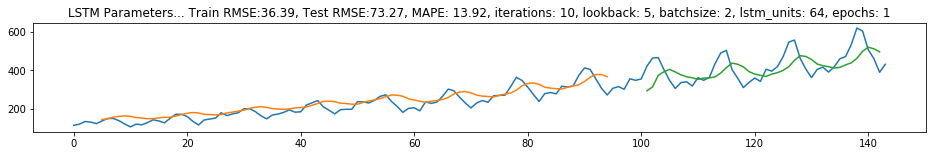

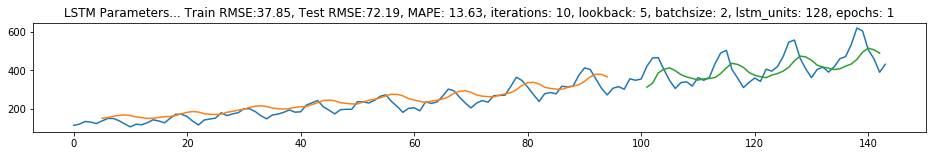

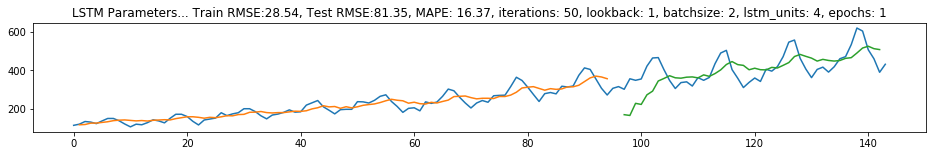

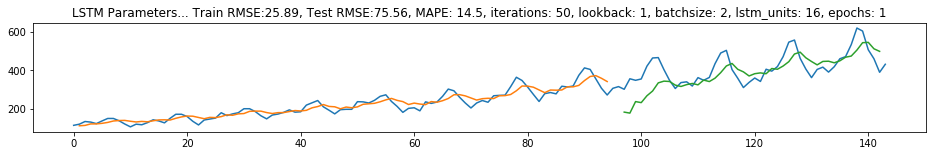

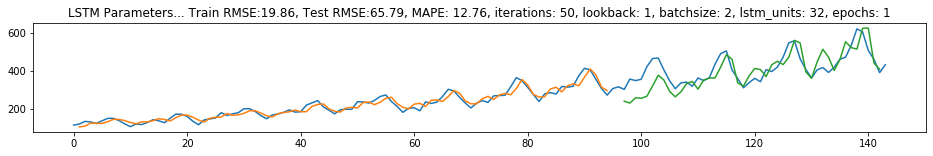

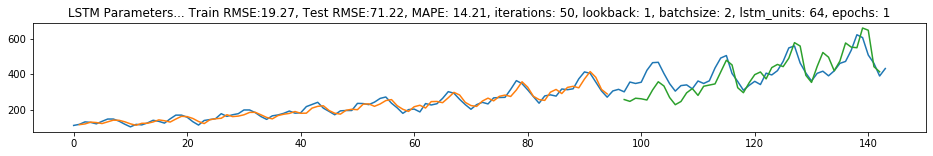

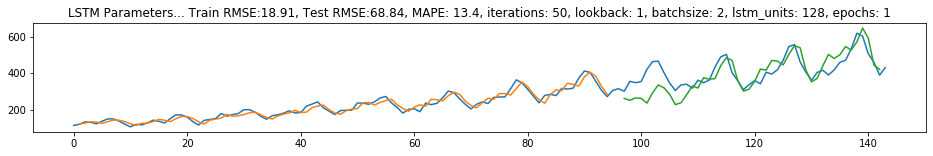

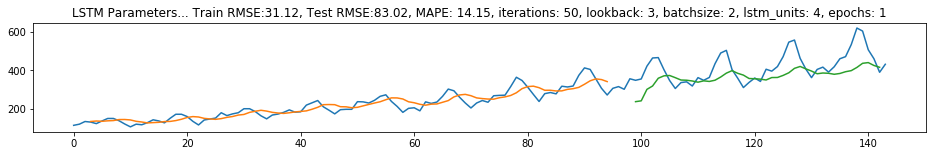

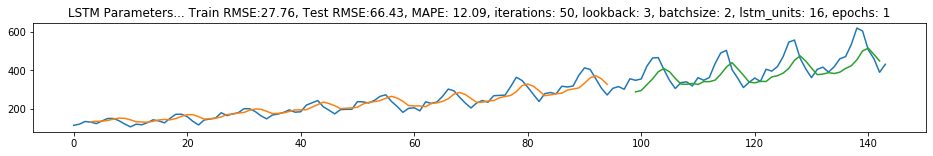

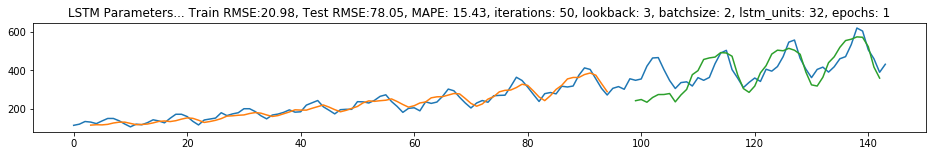

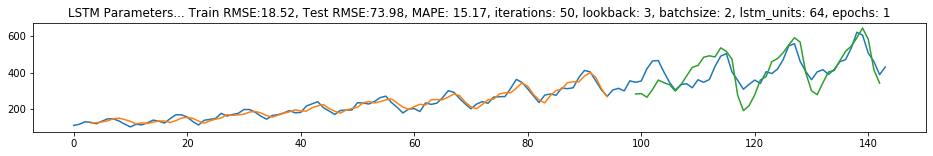

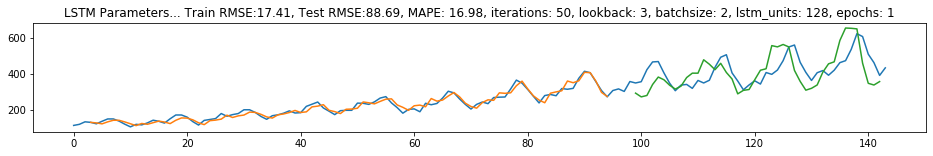

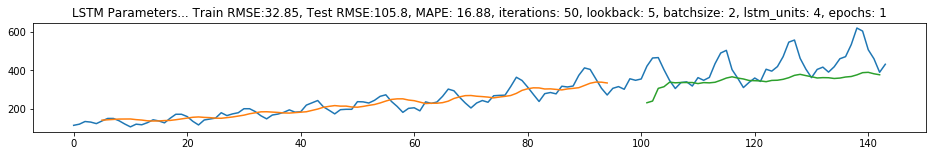

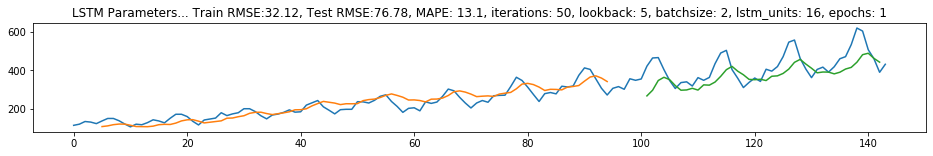

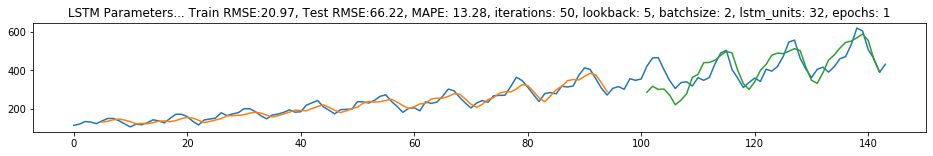

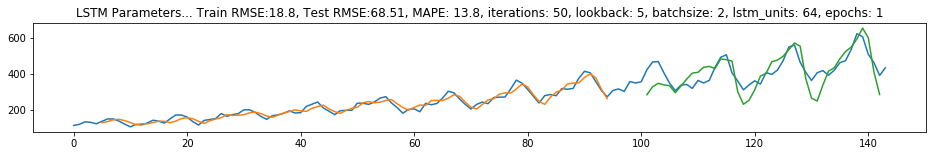

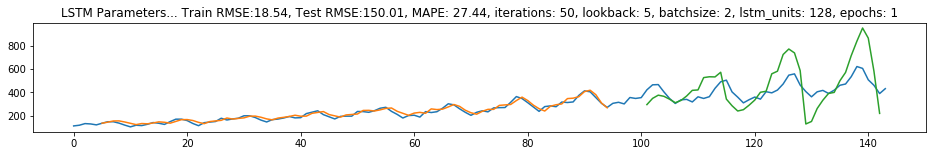

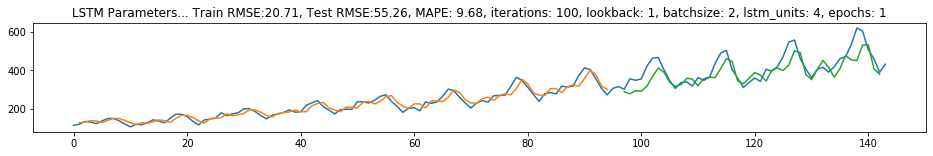

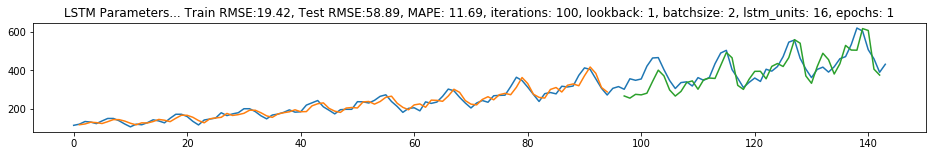

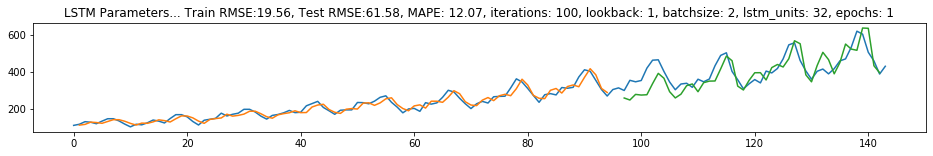

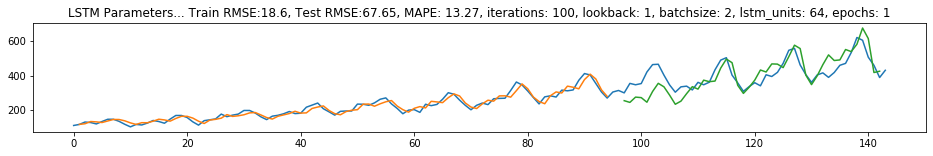

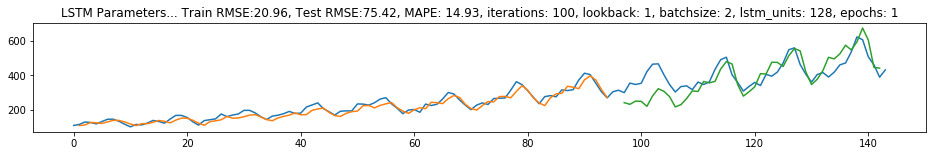

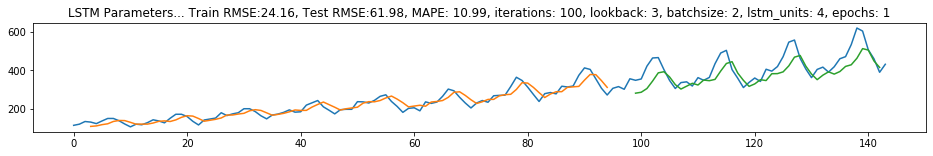

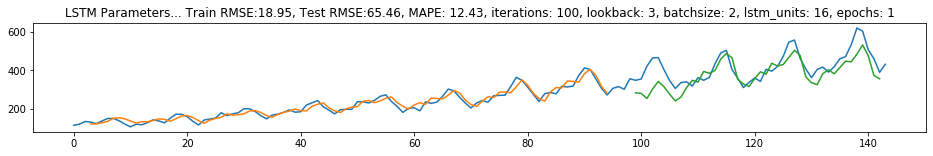

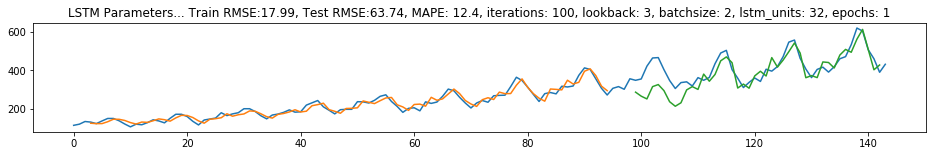

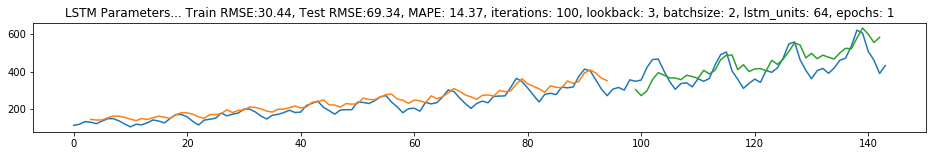

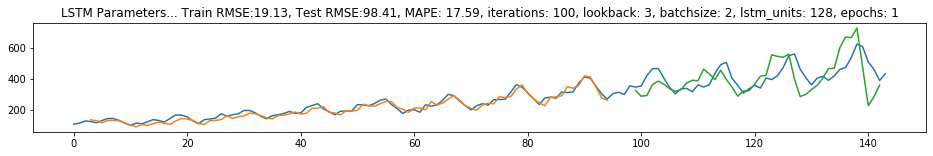

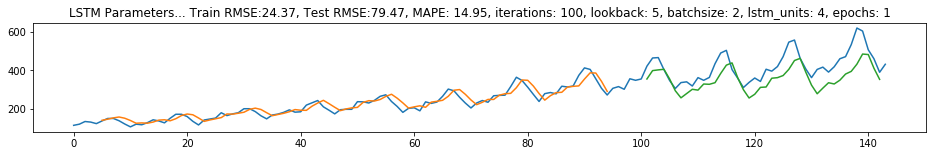

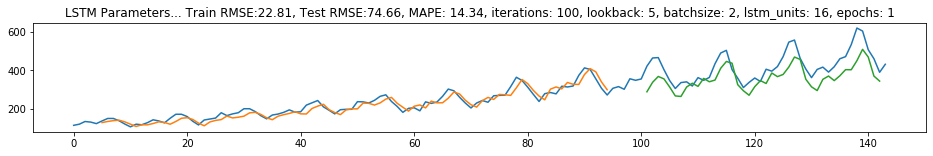

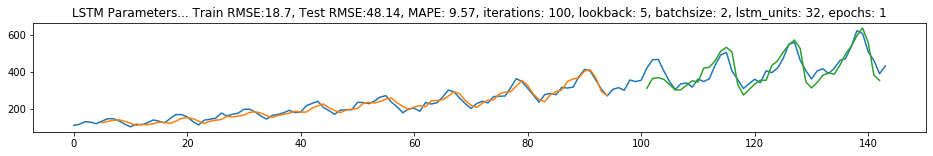

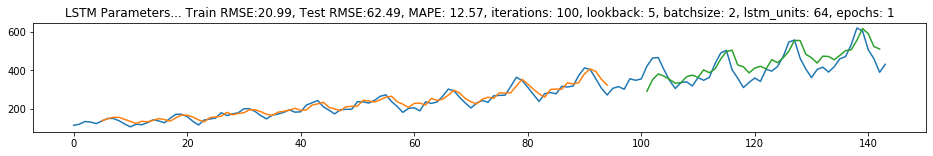

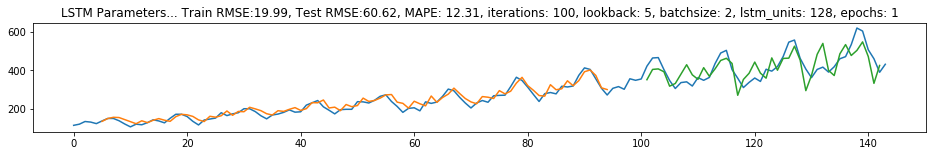

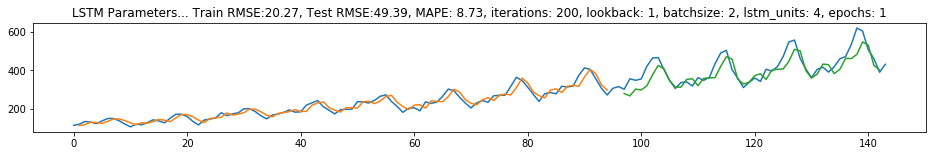

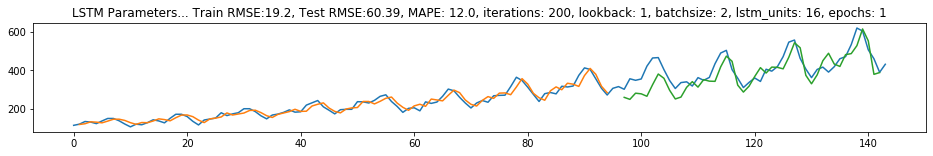

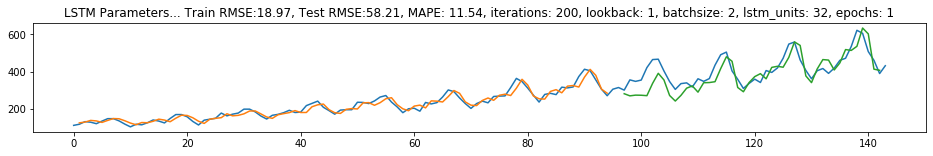

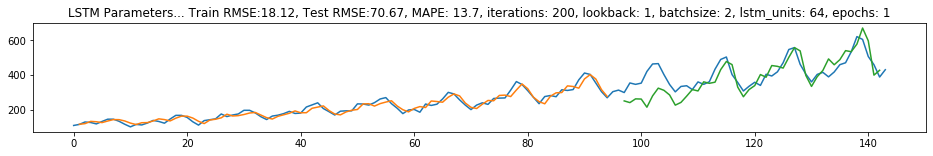

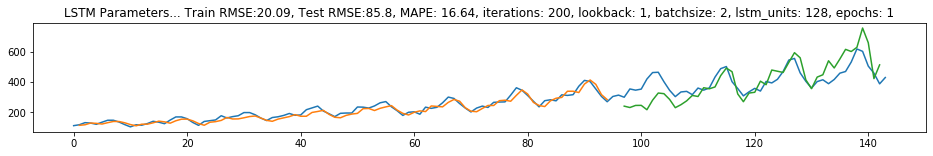

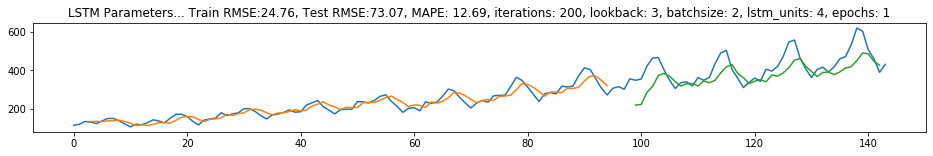

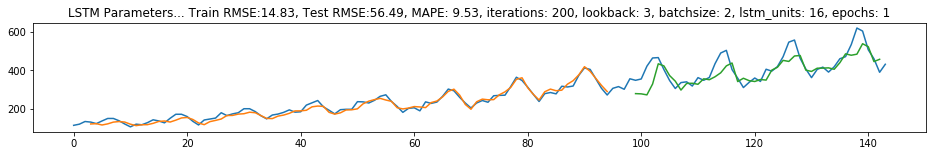

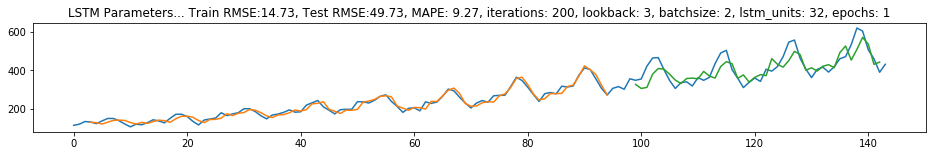

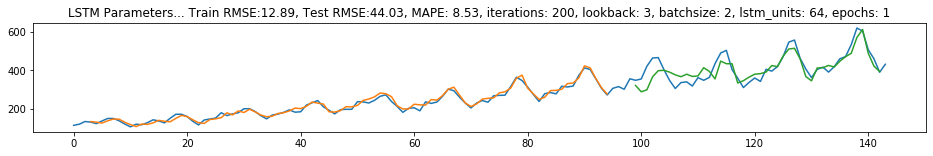

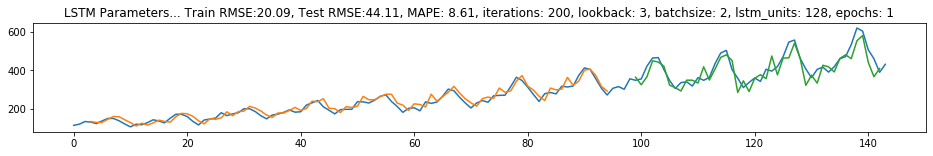

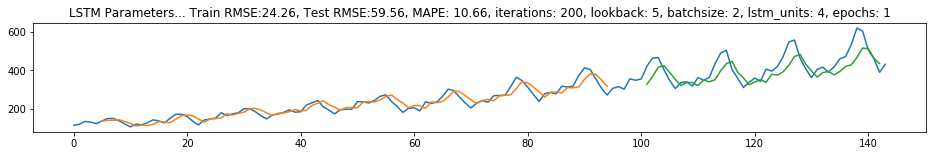

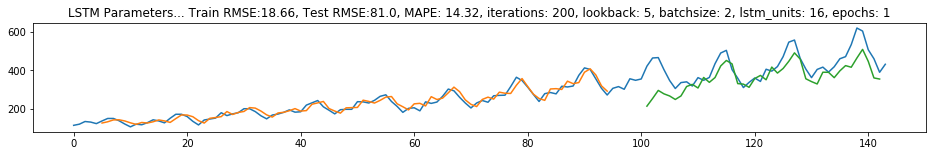

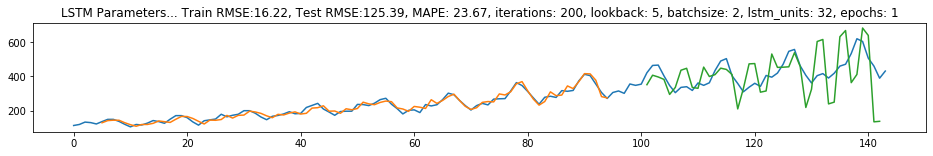

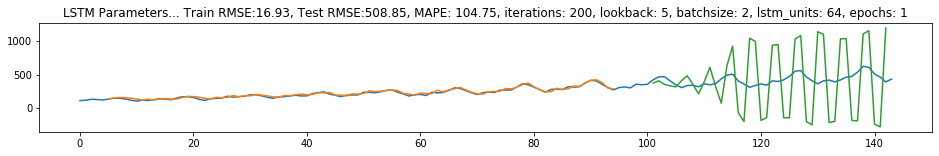

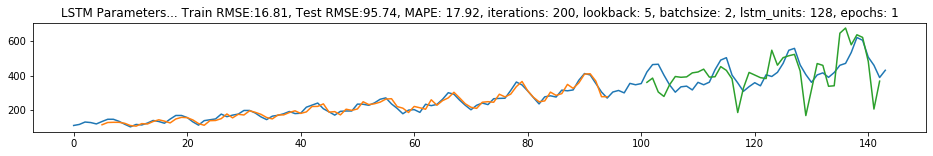

In [205]:
grid = ParameterGrid(search_best_config)
x = []
y = []
name = []

for i, params in enumerate(grid):
    iterations, testScore = perform_lstm(**params, ii=i)
    x.append(iterations)
    y.append(testScore)
    name.append(str(params.values()))

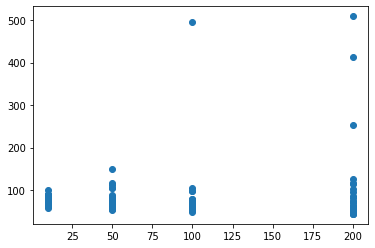

In [206]:
plt.scatter(x,y, data=name)
plt.show()

In [214]:
name[0]

'dict_values([1, 1, 10, 1, 4])'

In [219]:
with open('name.pkl', 'rb') as input_file:
    ls = pickle.load(input_file)

In [ ]:
import pickle